In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
import shutil

# Try to remove the tree; if it fails, throw an error using try...except.
try:
    shutil.rmtree("/content/sample_data")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

In [4]:
# Clone from Github Repository
! git init .
! git remote add origin https://github.com/rmislam/PythonSIFT.git
! git pull origin master
# ! git pull origin main

Reinitialized existing Git repository in /content/.git/
error: remote origin already exists.
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 97 (delta 1), reused 2 (delta 0), pack-reused 91
Unpacking objects: 100% (97/97), 379.22 KiB | 2.85 MiB/s, done.
From https://github.com/rmislam/PythonSIFT
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [5]:
import cv2
import pysift

image = cv2.imread('/content/box_in_scene.png', 0)
keypoints, descriptors = pysift.computeKeypointsAndDescriptors(image)

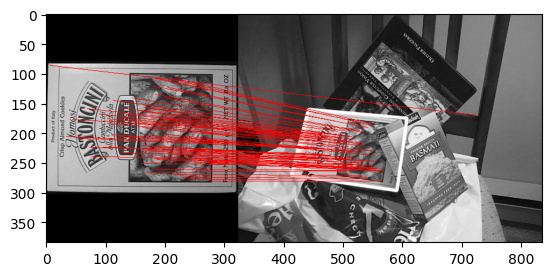

In [6]:
import numpy as np
import cv2
import pysift
from matplotlib import pyplot as plt
import logging
logger = logging.getLogger(__name__)

MIN_MATCH_COUNT = 10

img1 = cv2.imread('box.png', 0)           # queryImage
img2 = cv2.imread('box_in_scene.png', 0)  # trainImage

# Compute SIFT keypoints and descriptors
kp1, des1 = pysift.computeKeypointsAndDescriptors(img1)
kp2, des2 = pysift.computeKeypointsAndDescriptors(img2)

# Initialize and use FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    # Estimate homography between template and scene
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

    # Draw detected template in scene image
    h, w = img1.shape
    pts = np.float32([[0, 0],
                      [0, h - 1],
                      [w - 1, h - 1],
                      [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

    h1, w1 = img1.shape
    h2, w2 = img2.shape
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)

    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = img1
        newimg[:h2, w1:w1 + w2, i] = img2

    # Draw SIFT keypoint matches
    for m in good:
        pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1] + hdif))
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1]))
        cv2.line(newimg, pt1, pt2, (255, 0, 0))

    plt.imshow(newimg)
    plt.show()
else:
    print("Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT))